## Load BiomedCLIP model

In [ ]:
import json
from urllib.request import urlopen
from PIL import Image
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset
from huggingface_hub import hf_hub_download
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS
import random
from collections import defaultdict
from PIL import Image


# Download the model and config files
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_pytorch_model.bin",
    local_dir="checkpoints"
)
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_config.json",
    local_dir="checkpoints"
)


# Load the model and config files 
model_name = "biomedclip_local"

with open("checkpoints/open_clip_config.json", "r") as f:
    config = json.load(f)
    model_cfg = config["model_cfg"]
    preprocess_cfg = config["preprocess_cfg"]


if (not model_name.startswith(HF_HUB_PREFIX)
    and model_name not in _MODEL_CONFIGS
    and config is not None):
    _MODEL_CONFIGS[model_name] = model_cfg

tokenizer = get_tokenizer(model_name)

model, _, preprocess = create_model_and_transforms(
    model_name=model_name,
    pretrained="checkpoints/open_clip_pytorch_model.bin",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()},
)

In [ ]:
from torchvision import transforms
import random
from collections import defaultdict
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from PIL import Image
import torch

class FewShotImageFolder(Dataset):
    def __init__(self, root, num_shots, transform=None, test_transform=None, seed=42):
        super().__init__()
        self.root = root
        self.num_shots = num_shots
        self.transform = transform
        self.test_transform = test_transform
        
        full_dataset = ImageFolder(root)
        self.class_to_idx = full_dataset.class_to_idx

        label_to_samples = defaultdict(list)
        for path, label in full_dataset.samples:
            label_to_samples[label].append(path)
        
        random.seed(seed)
        
        self.train_samples = []
        self.train_targets = []
        self.test_samples = []
        self.test_targets = []

        for label, samples in label_to_samples.items():
            if len(samples) <= num_shots:
                sampled = samples
                remain = []
            else:
                sampled = random.sample(samples, num_shots)
                remain = [s for s in samples if s not in sampled]

            self.train_samples.extend(sampled)
            self.train_targets.extend([label] * len(sampled))
            self.test_samples.extend(remain)
            self.test_targets.extend([label] * len(remain))

        # 默认使用训练集
        combined = list(zip(self.train_samples, self.train_targets))
        random.shuffle(combined)
        self.samples, self.targets = zip(*combined)
        self.samples = list(self.samples)
        self.targets = list(self.targets)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path = self.samples[idx]
        label = self.targets[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label

    def get_test_set(self):
        return SimpleImageDataset(self.test_samples, self.test_targets,self.test_transform)



In [ ]:
# from dataset.dataset import Chestxray14_Dataset
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" 
# Basic transform compatible with CLIP input size & normalization
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),           
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),       
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])

dataset_root = r'D:\MedicalVLMs\data\LC25k'

fewshot_dataset = FewShotImageFolder(root=dataset_root, num_shots=16, transform=test_transform, test_transform = test_transform, seed=1111)

from torch.utils.data import DataLoader
support_loader = DataLoader(fewshot_dataset, batch_size=32, shuffle=True)

test_dataset = fewshot_dataset.get_test_set()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(fewshot_dataset)}")
print(f"Test size: {len(test_dataset)}")



idx_to_folder = {v: k for k, v in fewshot_dataset.class_to_idx.items()}
class_names = [folder_name for idx, folder_name in sorted(idx_to_folder.items())]
print(class_names)
num_classes = len(class_names)

model.to(device)
# prompt_templates = [
#         "a photo of {}",
#         "{} presented in image",
#     ]
# prompt_templates = [
#         "a photo of chest X-ray showing {}",
#         "a chest X-ray showing {}.",
#         "evidence of {} in lungs",
#         "radiographic signs of {}.",
#         "{} presented in image.",
#         "a patient diagnosed with {} in chest X-ray."
#     ]
prompt_templates = [
    "a photo of {}",
    "a chest X-ray showing {}",
    "a photo of chest X-ray showing {}",
    "radiographic signs of {}",
    "evidence of {} in lungs",
    "an X-ray of lungs with {}",
    "chest radiograph indicating {}",
    "X-ray scan showing {}",
    "frontal chest X-ray with {}",
    "PA chest X-ray of {}",
    "lateral chest X-ray of {}",
    "radiological appearance of {}",
    "findings consistent with {} in chest X-ray",
    "X-ray showing features of {}",
    "lungs affected by {} in X-ray",
    "an X-ray demonstrating {}",
    "medical imaging revealing {}",
    "an image of chest radiograph showing {}",
    "a patient chest X-ray showing {}",
    "radiograph evidence of {}",
    "radiology scan depicting {}",
    "diagnostic chest X-ray of {}",
    "projection X-ray showing {}",
    "X-ray report consistent with {}",
    "lungs diagnosed with {} via X-ray"
]

prompts = [template.format(l) for l in class_names for template in prompt_templates]
tokens = tokenizer(prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features.view(len(class_names), len(prompt_templates), -1)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_feats_global = text_features.mean(dim=1)  # prompt ensemble

Train size: 32
Test size: 5824
['normal', 'pneumonia']


## Zero-shot Baseline

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" 
# Basic transform compatible with CLIP input size & normalization
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),           
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),       
    # transforms.Lambda(lambda img: img.convert("RGB")),      
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                         std=(0.26862954, 0.26130258, 0.27577711))  
])

dataset_root = r'D:\MedicalVLMs\data\LC25k'

fewshot_dataset = FewShotImageFolder(root=dataset_root, num_shots=16, transform=test_transform, test_transform = test_transform, seed=1111)

from torch.utils.data import DataLoader
support_loader = DataLoader(fewshot_dataset, batch_size=32, shuffle=True)

test_dataset = fewshot_dataset.get_test_set()
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(fewshot_dataset)}")
print(f"Test size: {len(test_dataset)}")



idx_to_folder = {v: k for k, v in fewshot_dataset.class_to_idx.items()}
class_names = [folder_name for idx, folder_name in sorted(idx_to_folder.items())]
print(class_names)
num_classes = len(class_names)

model.to(device)
# prompt_templates = [
#         "a photo of {}",
#         "{} presented in image",
#     ]
# prompt_templates = [
#         "a photo of chest X-ray showing {}",
#         "a chest X-ray showing {}.",
#         "evidence of {} in lungs",
#         "radiographic signs of {}.",
#         "{} presented in image.",
#         "a patient diagnosed with {} in chest X-ray."
#     ]
prompt_templates = [
    "a photo of {}",
    "a chest X-ray showing {}",
    "a photo of chest X-ray showing {}",
    "radiographic signs of {}",
    "evidence of {} in lungs",
    "an X-ray of lungs with {}",
    "chest radiograph indicating {}",
    "X-ray scan showing {}",
    "frontal chest X-ray with {}",
    "PA chest X-ray of {}",
    "lateral chest X-ray of {}",
    "radiological appearance of {}",
    "findings consistent with {} in chest X-ray",
    "X-ray showing features of {}",
    "lungs affected by {} in X-ray",
    "an X-ray demonstrating {}",
    "medical imaging revealing {}",
    "an image of chest radiograph showing {}",
    "a patient chest X-ray showing {}",
    "radiograph evidence of {}",
    "radiology scan depicting {}",
    "diagnostic chest X-ray of {}",
    "projection X-ray showing {}",
    "X-ray report consistent with {}",
    "lungs diagnosed with {} via X-ray"
]

prompts = [template.format(l) for l in class_names for template in prompt_templates]
tokens = tokenizer(prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features.view(len(class_names), len(prompt_templates), -1)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_feats_global = text_features.mean(dim=1)  # prompt ensemble

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

device = "cuda" if torch.cuda.is_available() else "cpu"

all_labels, all_logits, all_probs = [], [], []
all_preds = []

idx_to_folder = {v: k for k, v in fewshot_dataset.class_to_idx.items()}
class_names = [folder_name for idx, folder_name in sorted(idx_to_folder.items())]
print(class_names)
num_classes = len(class_names)
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # image & text features (保留 L2 norm)
        image_feats = model.encode_image(images).float()
        image_feats /= image_feats.norm(dim=-1, keepdim=True)

        text_feats_norm = text_feats_global.float().to(device)
        text_feats_norm /= text_feats_norm.norm(dim=-1, keepdim=True)

        # logits & probs
        logits = model.logit_scale.exp()*image_feats @ text_feats_norm.T ## model.logit_scale.exp(): 85.2323
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(labels.cpu())
        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

all_labels = torch.cat(all_labels).numpy()
all_logits = torch.cat(all_logits).numpy()
all_probs = torch.cat(all_probs).numpy()
all_preds = torch.cat(all_preds).numpy()
num_classes = len(class_names)

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 11})
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
# plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === AUROC ===
num_classes = len(class_names)
try:
    onehot_labels = F.one_hot(torch.tensor(all_labels), num_classes=num_classes).numpy()
    aucs = roc_auc_score(onehot_labels, all_probs, average=None)
    for i, auc in enumerate(aucs):
        print(f"Class {class_names[i]}: AUROC = {auc:.4f}")
    print(f"Averaged AUROC: {aucs.mean():.4f}")
except Exception as e:
    print("Error calculating AUROC:", e)

import numpy as np

# Predicted class
preds = np.argmax(all_probs, axis=1)  # or np.argmax(all_logits, axis=1)

# Compute accuracy
accuracy = (preds == all_labels).mean()
print(f"Test set accuracy: {accuracy:.4f}")

import numpy as np

# Predicted class
preds = np.argmax(all_probs, axis=1)

# Overall accuracy (what you already have)
accuracy = (preds == all_labels).mean()
# === Per-class accuracy ===
num_classes = len(class_names)
per_class_acc = []
for c in range(num_classes):
    # indices of samples belonging to class c
    idx = np.where(np.array(all_labels) == c)[0]
    if len(idx) > 0:
        acc_c = (preds[idx] == np.array(all_labels)[idx]).mean()
    else:
        acc_c = np.nan  # handle case with no samples for class
    per_class_acc.append(acc_c)
    print(f"Class {class_names[c]}: Accuracy = {acc_c:.4f}")

# === Average (balanced) accuracy ===
avg_class_acc = np.nanmean(per_class_acc)
print(f"Average per-class accuracy: {avg_class_acc:.4f}")

from sklearn.metrics import f1_score, classification_report

# === Macro / Weighted F1 ===
f1_macro = f1_score(all_labels, preds, average='macro')
f1_weighted = f1_score(all_labels, preds, average='weighted')
f1_micro = f1_score(all_labels, preds, average='micro')

print(f"F1-macro: {f1_macro:.4f}")
print(f"F1-weighted: {f1_weighted:.4f}")
print(f"F1-micro: {f1_micro:.4f}")

# === Per-class F1 ===
per_class_f1 = f1_score(all_labels, preds, average=None)
for i, f1 in enumerate(per_class_f1):
    print(f"Class {class_names[i]}: F1 = {f1:.4f}")

# === Full classification report (precision/recall/F1) ===
print("\nClassification Report:")
print(classification_report(all_labels, preds, target_names=class_names, digits=4))

## Training-free Inter-Class Logits Adaptation (TILA)

### Compute equivalent logit scale

In [ ]:
# -------------------------------
# 1️⃣ Collect support logits + compute class-wise bias
# -------------------------------
support_logits_list = []
all_labels_train = []

model.to(device)
prompts = [template.format(l) for l in class_names for template in prompt_templates]
tokens = tokenizer(prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features.view(len(class_names), len(prompt_templates), -1)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_feats = text_features.mean(dim=1)  # prompt ensemble

with torch.no_grad():
    for images, labels in support_loader:  # few-shot support set
        images = images.to(device)
        labels = labels.to(device)
        all_labels_train.append(labels.cpu())

        # Encode and normalize
        image_feats = model.encode_image(images).float()
        image_feats /= image_feats.norm(dim=-1, keepdim=True)

        text_feats_norm = text_feats.float().to(device)
        # text_feats_norm /= text_feats_norm.norm(dim=-1, keepdim=True)

        # Raw logits
        # logits = image_feats @ text_feats_norm.T
        logits = model.logit_scale.exp() * (image_feats @ text_feats_norm.T)
        support_logits_list.append(logits.cpu())

support_logits = torch.cat(support_logits_list, dim=0)  # [N_train, num_classes]
all_labels_train = torch.cat(all_labels_train, dim=0)

num_classes = support_logits.size(1)

# -------------------------------
# 2️⃣ Compute min & max per sample
# -------------------------------
support_logits_min, _ = support_logits.min(dim=1, keepdim=True)
support_logits_max, _ = support_logits.max(dim=1, keepdim=True)

import torch
import torch.nn.functional as F

device = "cuda"

num_classes = support_logits.size(1)

# -------------------------------
# 1️⃣ Compute per-class mean & std from support set
# -------------------------------
lZS_mean = torch.zeros(num_classes, device=device)
lZS_std  = torch.zeros(num_classes, device=device)

all_labels_train = []
for _, labels in support_loader:
    all_labels_train.append(labels)
all_labels_train = torch.cat(all_labels_train).to(device)

support_logits = support_logits.to(device) 
for c in range(num_classes):
    mask = (all_labels_train == c)
    if mask.sum() == 0:
        lZS_mean[c] = 0.0
        lZS_std[c]  = 1.0
    else:
        class_logits = support_logits[mask, c]
        lZS_mean[c] = class_logits.mean()
        lZS_std[c]  = class_logits.std().clamp(min=1e-6)

# -------------------------------
# 2️⃣ Compute equivalent logit_scale
# -------------------------------
orig_logit_scale = model.logit_scale.exp
# orig_logit_scale = 85
mean_sigma = lZS_std.mean().item()   # 可以用平均 std 作为整体缩放参考
equiv_logit_scale = orig_logit_scale / mean_sigma

print(f"Original logit_scale: {orig_logit_scale:.3f}")
print(f"Equivalent logit_scale from class-wise z-score: {equiv_logit_scale:.3f}")

Original logit_scale: 85.000
Equivalent logit_scale from class-wise z-score: 36.345


In [ ]:
from TILA import *
beta_ot = 10             
layers = [3,5,7,8,9,10,11]
num_layer_to_use = 4

# ------------------ Step 1: Build support prototypes ------------------
layer_scores = compute_layer_scores(model, support_loader, layers, device)
best_layers = select_best_layers(layer_scores, top_k=num_layer_to_use, final_layer=11)
weights = compute_adaptive_layer_weights(layer_scores, best_layers)

cache_keys_layers, cache_values_layers, support_feats_layers, \
cache_keys_layers_proj, cache_values_layers_proj, support_feats_layers_proj = build_class_wise_prototypes(
    model, support_loader, best_layers, device, return_proj="True"
)

# ------------------ Step 2: Build multi-layer adapted text features ------------------
prompts = [template.format(c) for c in class_names for template in prompt_templates]
tokens = tokenizer(prompts).to(device)
with torch.no_grad():
    text_features = model.encode_text(tokens)
    text_features = text_features.view(len(class_names), len(prompt_templates), -1)
    text_features = F.normalize(text_features, dim=-1)

text_feats_global = build_text_prototypes(text_features, cache_keys_layers_proj, beta=20.0, weights=weights)

# ------------------ Step 3: Compute support alpha ------------------
alpha = compute_robust_support_alpha(support_feats_layers, smooth=False, alpha_min=0.1, alpha_max=0.5)
# print(f"Support alpha: {alpha:.4f}")

# ------------------ Step 4: Infer on test set ------------------
all_labels, all_preds = infer_fewshot(
    model, test_loader, 
    cache_keys_layers, cache_values_layers, text_feats_global, 
    equiv_logit_scale=equiv_logit_scale, a=alpha, beta_ot=10, device=device, layers=best_layers
)

# ------------------ Step 5: Compute metrics ------------------
from sklearn.metrics import balanced_accuracy_score, f1_score
acc = balanced_accuracy_score(all_labels, all_preds)
f1_macro = f1_score(all_labels, all_preds, average='macro')
print(f"Test Accuracy: {acc:.4f}, F1-macro: {f1_macro:.4f}")

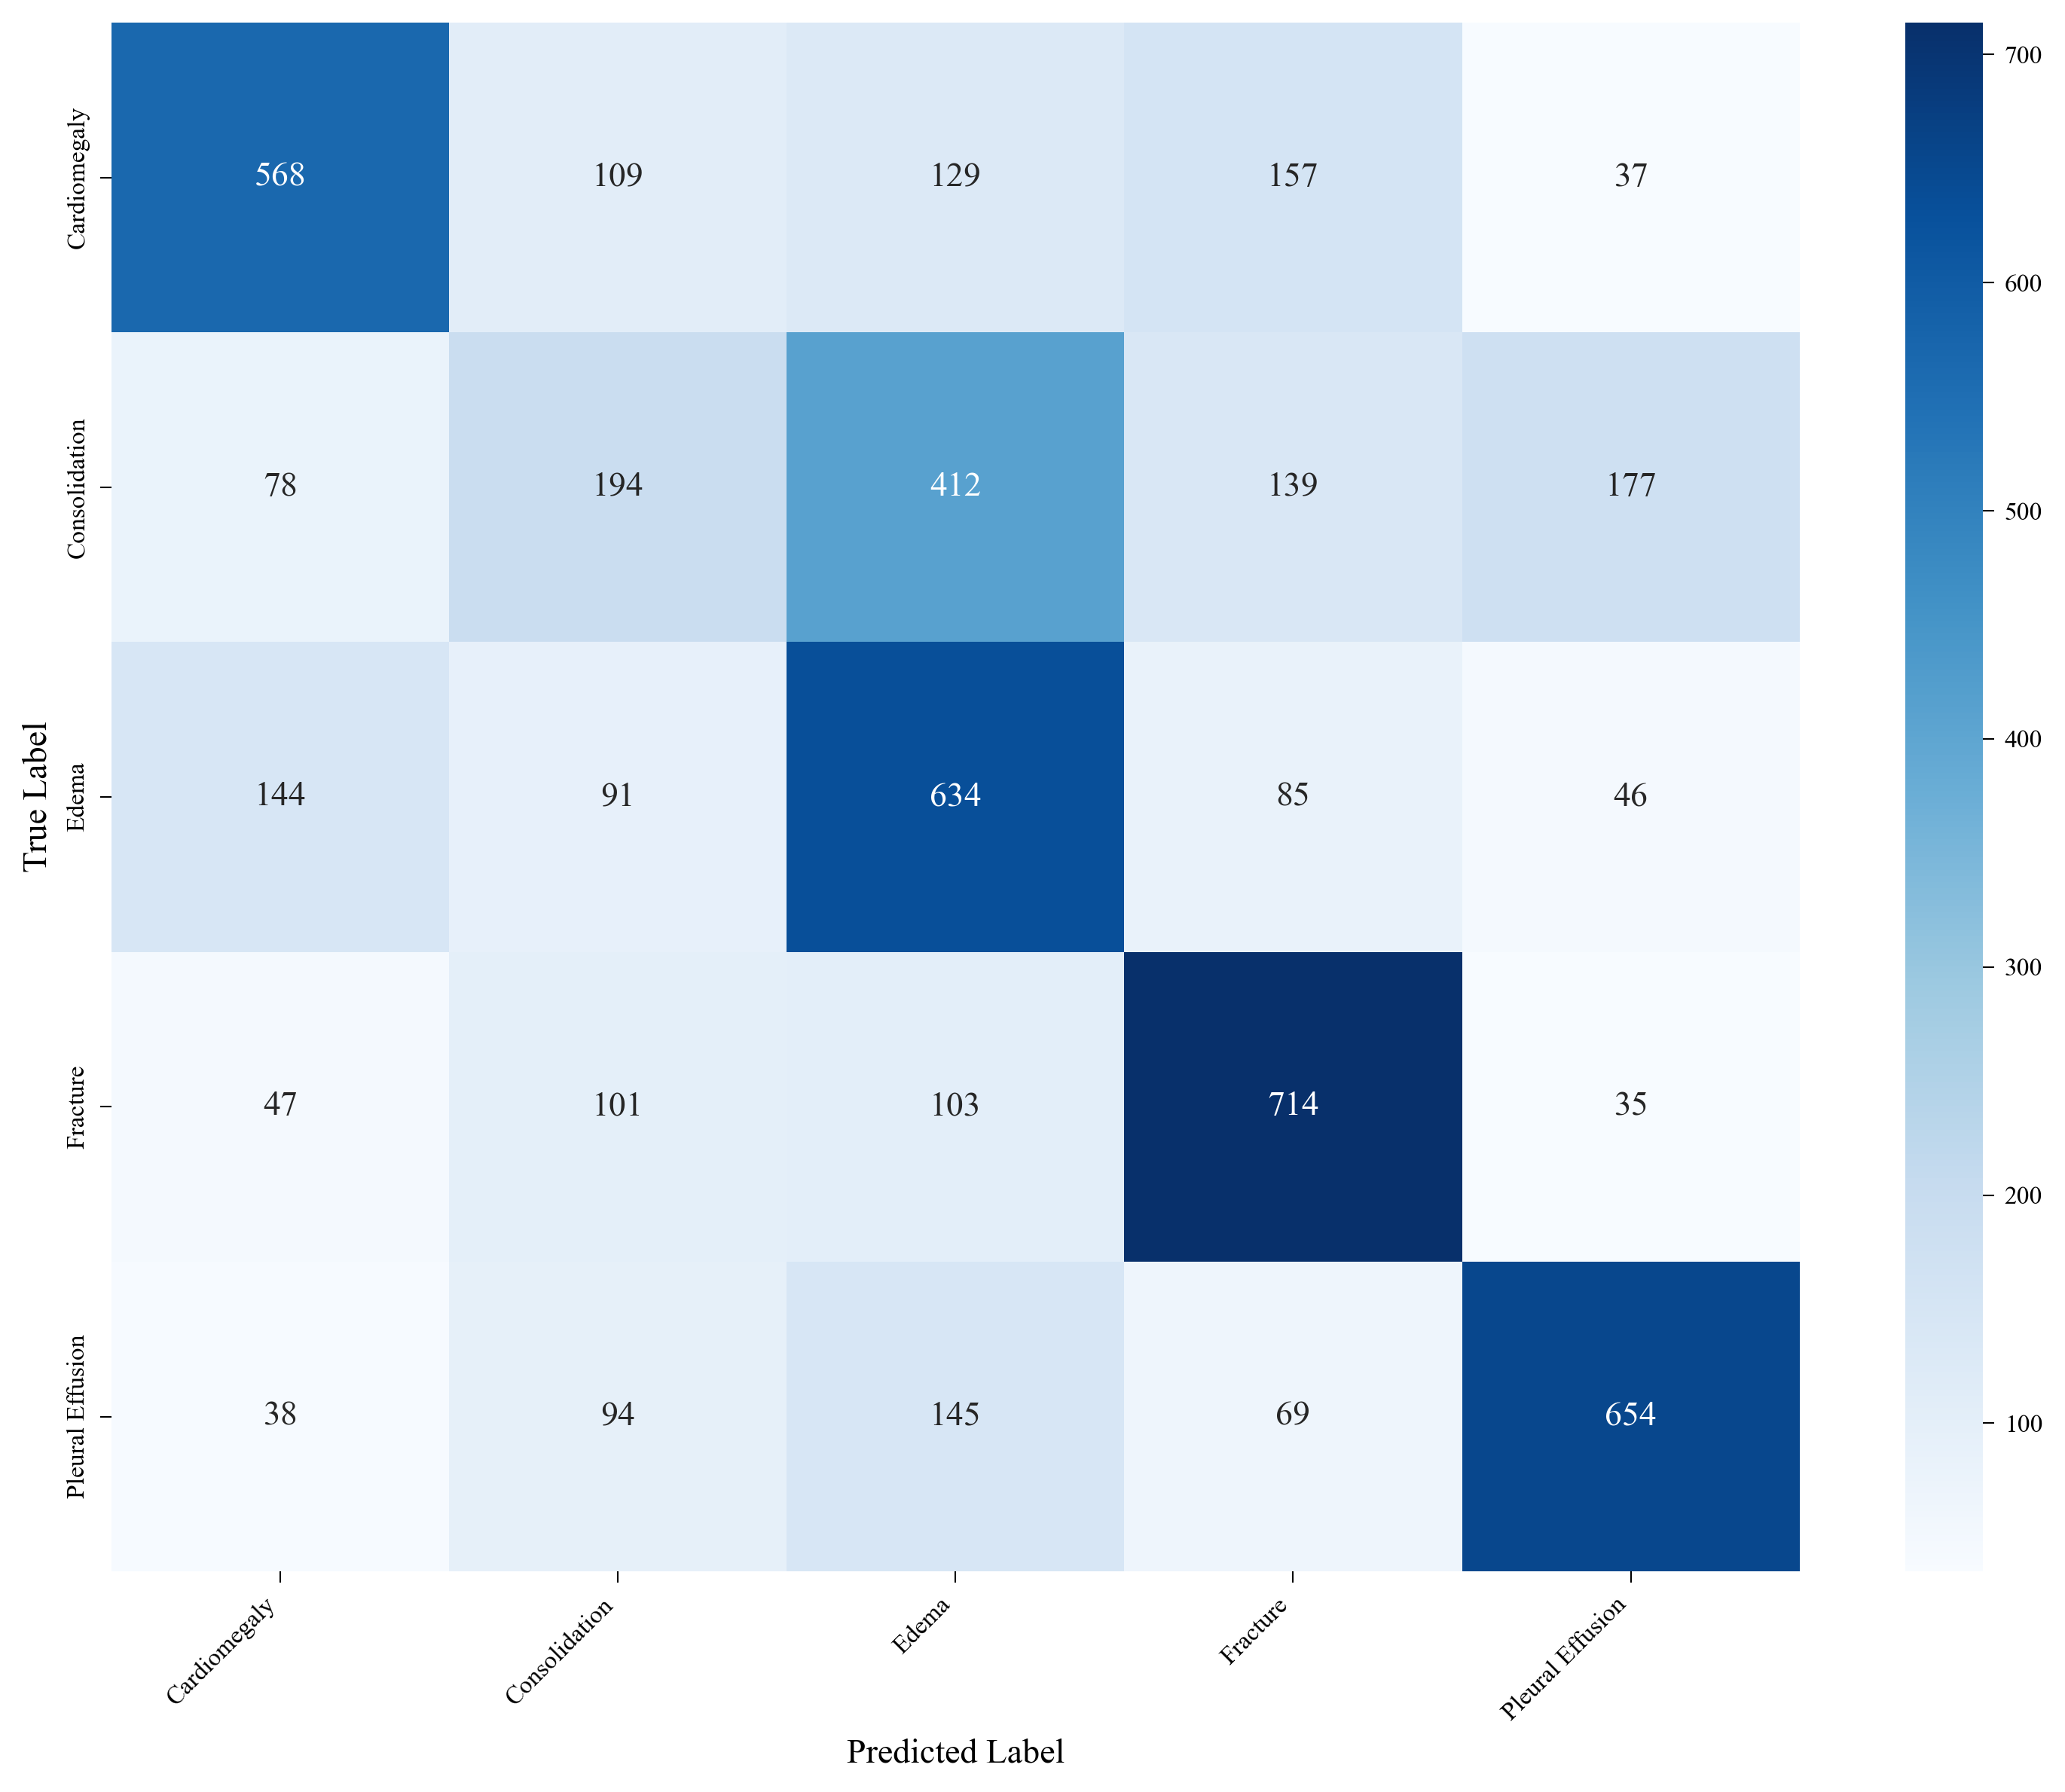

Class Cardiomegaly: AUROC = 0.8435
Class Consolidation: AUROC = 0.6138
Class Edema: AUROC = 0.7949
Class Fracture: AUROC = 0.8855
Class Pleural Effusion: AUROC = 0.8715
Averaged AUROC: 0.8018
Test set accuracy: 0.5528
Class Cardiomegaly: Accuracy = 0.5680
Class Consolidation: Accuracy = 0.1940
Class Edema: Accuracy = 0.6340
Class Fracture: Accuracy = 0.7140
Class Pleural Effusion: Accuracy = 0.6540
Average per-class accuracy: 0.5528
F1-macro: 0.5409
F1-weighted: 0.5409
F1-micro: 0.5528
Class Cardiomegaly: F1 = 0.6059
Class Consolidation: F1 = 0.2442
Class Edema: F1 = 0.5233
Class Fracture: F1 = 0.6599
Class Pleural Effusion: F1 = 0.6711

Classification Report:
                  precision    recall  f1-score   support

    Cardiomegaly     0.6491    0.5680    0.6059      1000
   Consolidation     0.3294    0.1940    0.2442      1000
           Edema     0.4455    0.6340    0.5233      1000
        Fracture     0.6134    0.7140    0.6599      1000
Pleural Effusion     0.6891    0.6540   

In [68]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 11})
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
# plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === AUROC ===
num_classes = len(class_names)
try:
    onehot_labels = F.one_hot(torch.tensor(all_labels), num_classes=num_classes).numpy()
    aucs = roc_auc_score(onehot_labels, all_probs, average=None)
    for i, auc in enumerate(aucs):
        print(f"Class {class_names[i]}: AUROC = {auc:.4f}")
    print(f"Averaged AUROC: {aucs.mean():.4f}")
except Exception as e:
    print("Error calculating AUROC:", e)

import numpy as np

# Predicted class
preds = np.argmax(all_probs, axis=1)  # or np.argmax(all_logits, axis=1)

# Compute accuracy
accuracy = (preds == all_labels).mean()

print(f"Test set accuracy: {accuracy:.4f}")

import numpy as np

# Predicted class
preds = np.argmax(all_probs, axis=1)

# Overall accuracy (what you already have)
accuracy = (preds == all_labels).mean()
# === Per-class accuracy ===
num_classes = len(class_names)
per_class_acc = []
for c in range(num_classes):
    # indices of samples belonging to class c
    idx = np.where(np.array(all_labels) == c)[0]
    if len(idx) > 0:
        acc_c = (preds[idx] == np.array(all_labels)[idx]).mean()
    else:
        acc_c = np.nan  # handle case with no samples for class
    per_class_acc.append(acc_c)
    print(f"Class {class_names[c]}: Accuracy = {acc_c:.4f}")

# === Average (balanced) accuracy ===
avg_class_acc = np.nanmean(per_class_acc)
print(f"Average per-class accuracy: {avg_class_acc:.4f}")

from sklearn.metrics import f1_score, classification_report

# === Macro / Weighted F1 ===
f1_macro = f1_score(all_labels, preds, average='macro')
f1_weighted = f1_score(all_labels, preds, average='weighted')
f1_micro = f1_score(all_labels, preds, average='micro')

print(f"F1-macro: {f1_macro:.4f}")
print(f"F1-weighted: {f1_weighted:.4f}")
print(f"F1-micro: {f1_micro:.4f}")

# === Per-class F1 ===
per_class_f1 = f1_score(all_labels, preds, average=None)
for i, f1 in enumerate(per_class_f1):
    print(f"Class {class_names[i]}: F1 = {f1:.4f}")

# === Full classification report (precision/recall/F1) ===
print("\nClassification Report:")
print(classification_report(all_labels, preds, target_names=class_names, digits=4))